# **NLP END-SEM PROJECT**

Submiited By:

**Jitendra Singh Bhadoria - MCS22026 \\
Vidit Raj Singh - MCS22004**



---



---



# **Fine-tuning the BART Model for Natural Language-to-SQL Query Generation on the Spider Dataset**

In this project, we explore using BART (Bidirectional and Auto-Regressive Transformer) for text-to-SQL query generation. We describe our methodology, which involves fine-tuning BART on the Spider dataset of natural language queries and their corresponding SQL queries.



---



---





### 1. Mounting the Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Installing the required Packages

In [ ]:
!pip install -q datasets
!pip install -q transformers
!pip install -q rouge_score
!pip install -q evaluate
!pip install -q huggingface_hub
!pip install -q PyDrive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.0 MB/s eta 0

### 3. Logging in to Hugging Face Hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

### 4. Importing the required libraries

In [ ]:
import pandas as pd
import torch
import nltk
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_metric, Dataset
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### 5. Loading the ROUGE evaluation metric.

In [ ]:
rouge_score = evaluate.load("rouge")

### 6. Reading the Spider Dataset

In [ ]:
df = pd.read_json('/content/drive/MyDrive/NLP/SpiderDataset/train_spider.json')

### 7. Preview the contents of the loaded DataFrame

In [ ]:
df.head()

,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql
0,department_management,SELECT count(*) FROM head WHERE age > 56,"[SELECT, count, (, *, ), FROM, head, WHERE, ag...","[select, count, (, *, ), from, head, where, ag...",How many heads of the departments are older th...,"[How, many, heads, of, the, departments, are, ...","{'except': None, 'from': {'conds': [], 'table_..."
1,department_management,"SELECT name , born_state , age FROM head ORD...","[SELECT, name, ,, born_state, ,, age, FROM, he...","[select, name, ,, born_state, ,, age, from, he...","List the name, born state and age of the heads...","[List, the, name, ,, born, state, and, age, of...","{'except': None, 'from': {'conds': [], 'table_..."
2,department_management,"SELECT creation , name , budget_in_billions ...","[SELECT, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","List the creation year, name and budget of eac...","[List, the, creation, year, ,, name, and, budg...","{'except': None, 'from': {'conds': [], 'table_..."
3,department_management,"SELECT max(budget_in_billions) , min(budget_i...","[SELECT, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...",What are the maximum and minimum budget of the...,"[What, are, the, maximum, and, minimum, budget...","{'except': None, 'from': {'conds': [], 'table_..."
4,department_management,SELECT avg(num_employees) FROM department WHER...,"[SELECT, avg, (, num_employees, ), FROM, depar...","[select, avg, (, num_employees, ), from, depar...",What is the average number of employees of the...,"[What, is, the, average, number, of, employees...","{'except': None, 'from': {'conds': [], 'table_..."


### 8. Check the distribution of sequence lengths for the Queries in the Spider dataset

<Figure size 1000x600 with 0 Axes>

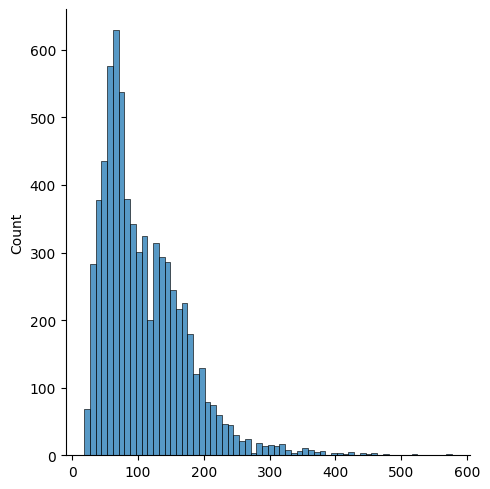

In [ ]:
l = []
for i in df['query']:
  l.append(len(i))

plt.figure(figsize = (10,6))
sns.displot(l)
plt.show()

### 9. Check the distribution of sequence lengths for the Natural Language Questions in the Spider dataset

<Figure size 1000x600 with 0 Axes>

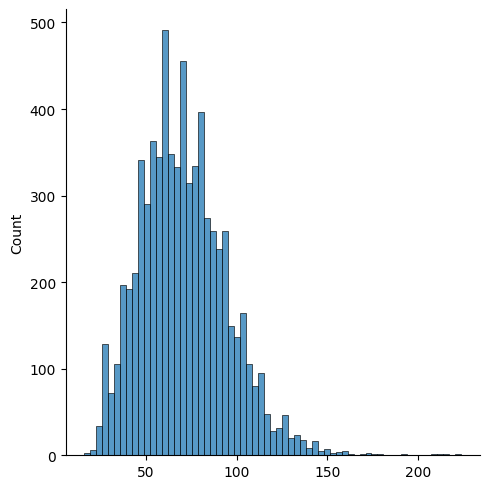

In [ ]:
l = []
for i in df['question']:
  l.append(len(i))

plt.figure(figsize = (10,6))
sns.displot(l)
plt.show()

### 10. Redifining the DataFrame

In [ ]:
df = df[['query','question']]

### 11. Splitting the DataFrame into training and validation set

In [ ]:
train_df, val_df = train_test_split(df, test_size = 0.05, random_state = 21)
print(train_df.shape)
print(val_df.shape)

(6650, 2)
(350, 2)


### 12. Converting Pandas DataFrames to Hugging Face Dataset Objects

In [ ]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
train_dataset = train_dataset.remove_columns(['__index_level_0__'])
val_dataset = val_dataset.remove_columns(['__index_level_0__'])
print(train_dataset)
print(val_dataset)

Dataset({
    features: ['query', 'question'],
    num_rows: 6650
})
Dataset({
    features: ['query', 'question'],
    num_rows: 350
})


### 13. Displaying a few examples from the Training Dataset

In [ ]:
print(train_dataset['query'][1] +" ---------------------> "+ train_dataset['question'][1])
print(train_dataset['query'][5] +" ---------------------> "+ train_dataset['question'][5])
print(train_dataset['query'][20] +" ---------------------> "+ train_dataset['question'][20])
print(train_dataset['query'][100] +" ---------------------> "+ train_dataset['question'][100])

SELECT location_code ,  location_name FROM Ref_locations ---------------------> List all location codes and location names.
SELECT count(*) FROM storm WHERE Number_Deaths  >  0 ---------------------> Count the number of storms in which at least 1 person died.
SELECT t1.last_name FROM staff AS t1 JOIN complaints AS t2 ON t1.staff_id  =  t2.staff_id ORDER BY t2.date_complaint_raised LIMIT 1 ---------------------> What is the last name of the staff who has handled the first ever complaint?
SELECT sum(revenue) ,  name FROM manufacturers GROUP BY name ---------------------> Find the total revenue for each manufacturer.




---



---



---

### 14. Loading the BART model and tokenizer from the Hugging Face Transformers library

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments

model_checkpoint = "facebook/bart-large-cnn"

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

### 15. Preprocessing the input data and preparing it for training the Seq2Seq Model

In [ ]:
max_input_length = 256
max_target_length = 256


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples['question'],
        max_length=max_input_length,
        truncation=True, padding = 'max_length'
    )
    labels = tokenizer(text_target = examples['query'], max_length=max_target_length, truncation=True, padding = 'max_length')
    model_inputs["labels"] = labels["input_ids"]
    model_inputs["labels_mask"] = labels["attention_mask"]
    return model_inputs

In [ ]:
tokenized_train_datasets = train_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/6650 [00:00<?, ? examples/s]

In [ ]:
tokenized_val_datasets = val_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

In [ ]:
tokenized_train_datasets = tokenized_train_datasets.remove_columns(['query','question'])
tokenized_val_datasets = tokenized_val_datasets.remove_columns(['query','question'])

print(tokenized_train_datasets)
print(tokenized_val_datasets)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels', 'labels_mask'],
    num_rows: 6650
})
Dataset({
    features: ['input_ids', 'attention_mask', 'labels', 'labels_mask'],
    num_rows: 350
})


### 16. Defining the Data Collator to be used during the training

In [ ]:
data_collator = DataCollatorForSeq2Seq(model = model,tokenizer = tokenizer,label_pad_token_id=-100)

### 17. Specifying the training arguments for the Seq2Seq Model

In [ ]:
batch_size = 8
learning_rate = 1e-4
args = Seq2SeqTrainingArguments(
    evaluation_strategy = "epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=5,
    num_train_epochs=5,
    predict_with_generate=True,
    fp16=False,
    push_to_hub = False
)

### 18. Defining the Compute Metrics function for evaluating the generated summaries using the Rouge Metric

In [ ]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    result = {key: value * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

### 19. Initializing a Seq2SeqTrainer Object for training and evaluation purpose

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_train_datasets,
    eval_dataset=tokenized_val_datasets,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

### 20. Training the model

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,0.240200,0.053889,50.449900,35.673700,45.890300,45.859800
2,0.034100,0.032283,53.711800,41.102700,50.246000,50.093300
3,0.022000,0.024865,55.282800,43.488200,52.188200,52.020600
4,0.009500,0.026531,55.615500,44.600600,52.415100,52.243900
5,0.003300,0.019284,55.887200,44.721400,53.039200,52.541500


TrainOutput(global_step=4160, training_loss=0.046835805117510836, metrics={'train_runtime': 7551.2916, 'train_samples_per_second': 4.403, 'train_steps_per_second': 0.551, 'total_flos': 1.8014057005056e+16, 'train_loss': 0.046835805117510836, 'epoch': 5.0})

### 21. Saving the trained model and Tokenizer to the Hugging Face Model Hub

In [ ]:
model.push_to_hub("jitendrasingh/BART_text_to_sql")
tokenizer.push_to_hub("jitendrasingh/BART_text_to_sql")
model.save_pretrained('/content/drive/MyDrive/NLP')

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

### 22. Evaluating the Trained Model

In [ ]:
trainer.evaluate()

{'eval_loss': 0.019283704459667206,
 'eval_rouge1': 55.8872,
 'eval_rouge2': 44.7214,
 'eval_rougeL': 53.0392,
 'eval_rougeLsum': 52.5415,
 'eval_runtime': 161.1012,
 'eval_samples_per_second': 2.173,
 'eval_steps_per_second': 0.273,
 'epoch': 5.0}



---



---



---



### 23. Loading the Trained model and tokenizer from the Hugging Face Model Hub

In [1]:
!pip install -q transformers
!pip install -q huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.1 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
model = AutoModelForSeq2SeqLM.from_pretrained("jitendrasingh/BART_text_to_sql")
tokenizer = AutoTokenizer.from_pretrained("jitendrasingh/BART_text_to_sql")

In [ ]:
device = 'cuda'
model.to(device)

In [ ]:
max_length = 256
# Preprocessing and defining the sequence length for training the models
max_input_length = 256
max_target_length = 256

def Text2SQL(input_text):
  model_inputs = tokenizer(
        input_text,
        max_length=max_input_length,
        truncation=True, padding = 'max_length'
    )
  # Tokenize the input text
  inputs = tokenizer(input_text, max_length=max_input_length, padding="max_length", truncation=True, return_tensors="pt")

  # Move the input tensors to the device
  input_ids = inputs['input_ids'].to(device)
  attention_mask = inputs['attention_mask'].to(device)
  # Generate the SQL query using the trained model
  generated_query_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=max_target_length, num_beams=5, early_stopping=True)
  # Decode the generated query to text
  generated_query_text = tokenizer.decode(generated_query_ids[0], skip_special_tokens=True)
  # Print the generated SQL query
  
  generated_query_text = generated_query_text[0:100]

  print(" "+generated_query_text)

In [ ]:
input_text = input("\n Enter Query in Natural Language: ")
input_text = str(input_text)

print("\n Generated SQL Query is : \n")
Text2SQL(input_text)


 Enter Query in Natural Language: List the creation year, name and budget of each department

 Generated SQL Query is : 

 SELECT creation,  name,  budget_in_billions_USD,  department_name,  creation_year FROM department_bu





---


---



---

